In [4]:
from models.auto_encoder import AutoEncoder
from torchsummary import summary
from numpy import random
from helpers_mod import plot_field_xy_from_tensor, MCSims
from models.lit_model import LitAE
import json
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = MCSims()

model_instance = AutoEncoder(json.load(open("config.json"))["model_params"])
litmodel = LitAE.load_from_checkpoint(
    "checkpoints/best-checkpoint-v1.ckpt", map_location="cpu", model=model_instance
)
model = litmodel.model
encoder = model.encoder

summary(model_instance.to(device), (3, 48, 48, 48))

# max and min values of the dataset
n = 1071
print(n)


original = dataset[n].float()  # Convert to float
reconstruct = model(original.unsqueeze(0).to(device))[0].squeeze(0).detach().cpu()

plot_field_xy_from_tensor(original) + plot_field_xy_from_tensor(reconstruct)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 48, 48, 48]           8,240
       BatchNorm3d-2        [-1, 8, 48, 48, 48]              16
              ReLU-3        [-1, 8, 48, 48, 48]               0
 AdaptiveMaxPool3d-4        [-1, 8, 24, 24, 24]               0
         ConvBlock-5        [-1, 8, 24, 24, 24]               0
            Conv3d-6       [-1, 16, 24, 24, 24]          43,920
       BatchNorm3d-7       [-1, 16, 24, 24, 24]              32
              ReLU-8       [-1, 16, 24, 24, 24]               0
 AdaptiveMaxPool3d-9       [-1, 16, 12, 12, 12]               0
        ConvBlock-10       [-1, 16, 12, 12, 12]               0
           Conv3d-11       [-1, 32, 12, 12, 12]          64,032
      BatchNorm3d-12       [-1, 32, 12, 12, 12]              64
             ReLU-13       [-1, 32, 12, 12, 12]               0
AdaptiveMaxPool3d-14          [-1, 32, 

BokehModel(combine_events=True, render_bundle={'docs_json': {'6e1f7abe-dd9a-4d30-92af-f7db117b27aa': {'version…

In [5]:
import hdbscan

# Encode the dataset
encoded_data = encoder(dataset[:].float().to(device)).detach().cpu()

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
labels = clusterer.fit_predict(encoded_data.cpu().numpy())

# print number of clusters and number of points in each cluster
for i in set(labels):
    print("Cluster {}: {}".format(i, sum(labels == i)))

df = dataset.data_frame
df["cluster"] = labels

: 

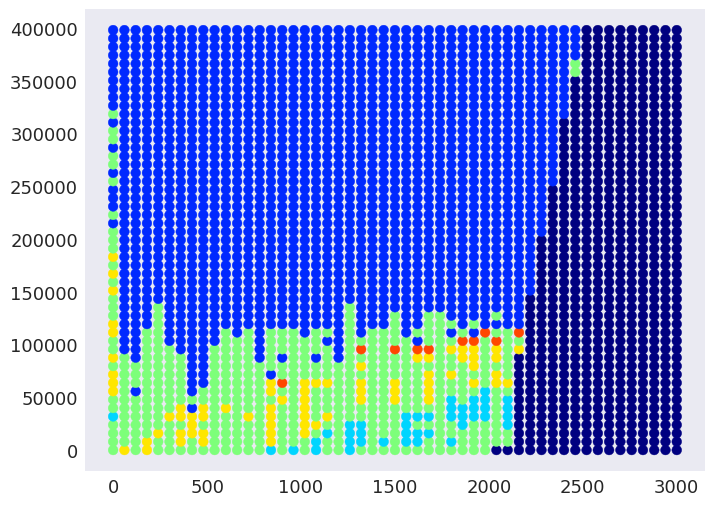

In [4]:
# plot H vs T with with different colors for each cluster
import matplotlib.pyplot as plt

# Create a list of unique clusters
unique_clusters = df["cluster"].unique()

# Assign a color for each cluster (using a colormap, e.g., 'viridis')
cmap = plt.cm.jet
colors = [cmap(i / len(unique_clusters)) for i in range(len(unique_clusters))]

# Map the cluster labels to the corresponding colors
color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}
df["color"] = df["cluster"].map(color_map)

# Plot with colors based on cluster
plt.scatter(df["T (K)"], df["H (A/m)"], c=df["color"], marker="o")
plt.show()

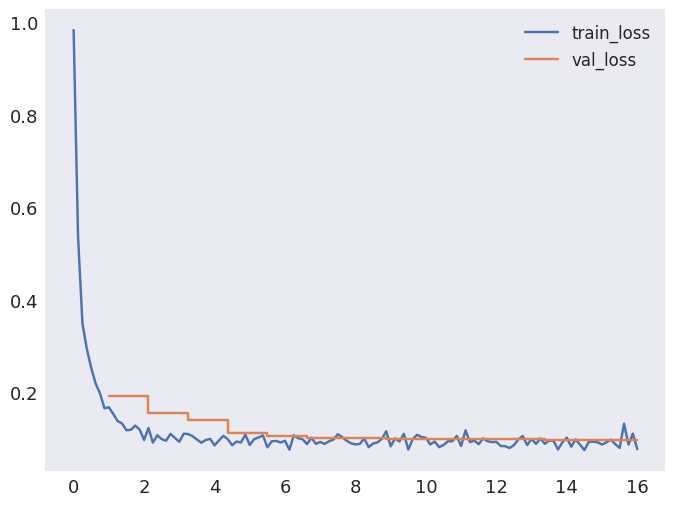

In [3]:
# plot metrics from a csv file
import matplotlib.pyplot as plt
import pandas as pd

# load the csv file

file_path = "logs/lightning_logs/version_0/metrics.csv"
df = pd.read_csv(file_path)
# use the last value of the train and val loss for each step if nan
df["train_loss"] = df["train_loss"].fillna(method="ffill")
df["val_loss"] = df["val_loss"].fillna(method="ffill")
# plot the metrics
plt.plot(df["step"]/8, df["train_loss"], label="train_loss")
plt.plot(df["step"]/8, df["val_loss"], label="val_loss")
plt.legend()
plt.show()
